In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

from neurodsp import filt
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

from scipy import signal

from sklearn.decomposition import FastICA, PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import time
import pyeeg

In [2]:
Pkl_Filename = 'raw_data_recording-8ch.pkl'
Pkl_Filename_2 = 'raw_data_recording-8ch-2.pkl'
data = []
data_2 = []
with open(Pkl_Filename, 'rb') as file:
    data = pickle.load(file)
    
with open(Pkl_Filename_2, 'rb') as file:
    data_2 = pickle.load(file)

In [3]:
def assemble_sort_raw_data(raw_data):
    sequenced_data = []
    for chunck in raw_data:
        if len(sequenced_data) == 0:
            sequenced_data = chunck
        else:
            sequenced_data = np.concatenate((sequenced_data, chunck), axis=1)
        
    # sort by the time ch, 22 (brainflow)
    sorted_data = sequenced_data[:,sequenced_data[22].argsort()]
    sorted_data[22] = sorted_data[22] - min(sorted_data[22])
    
    return sorted_data


def get_event_list(sorted_data):
    event_list = []
    for i in range(sorted_data.shape[1]):
        e_label = int(sorted_data[23][i])
        e_time = sorted_data[22][i]
        # 0 is no event, 9 is stop
        if e_label != 0 and e_label !=9:
            # epoch start, start in epoch, label
            event_list.append([e_time, 0, e_label])
        
    return event_list



def filter_eeg(ch_datas, sample_rate, f_range):
    filtered = []
    for ch in ch_datas:
        sig_filt = filt.filter_signal(ch,sample_rate, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
        test_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58,62), n_seconds=1)
        num_nans = sum(np.isnan(test_filt))
        sig_filt = np.concatenate(([0]*(num_nans//2), sig_filt, [0]*(num_nans//2)))
        sig_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58, 62), n_seconds=1)
        sig_filt = sig_filt[~np.isnan(sig_filt)]
        
        filtered.append(sig_filt)
    
    return np.array(filtered)


def plot_all_channels(ch_data, size=(12,8)):
    figure(figsize=size)
    for ch in ch_data:
        plt.plot(ch)

In [4]:
# raw_data = data+data_2
sorted_data = assemble_sort_raw_data(data_2)

event_list = get_event_list(sorted_data)
print(event_list)
selector = list(range(1,9)) #+ [22] # 22 is the time data
ch_data = sorted_data[selector]


[[3.385823965072632, 0, 3], [10.396805047988892, 0, 4], [18.39358687400818, 0, 1], [26.409024953842163, 0, 4], [32.41638994216919, 0, 2], [38.42348289489746, 0, 4], [44.43013095855713, 0, 4], [52.43594789505005, 0, 2], [59.43244910240173, 0, 3], [65.44359993934631, 0, 3], [72.44907808303833, 0, 4], [80.45319604873657, 0, 2], [88.46416401863098, 0, 2], [96.46643710136414, 0, 3], [104.47469687461853, 0, 2], [110.4878830909729, 0, 2], [116.49294900894165, 0, 4], [123.49427199363708, 0, 4], [129.49808287620544, 0, 4], [137.5113549232483, 0, 1]]


In [5]:
ch_data = filter_eeg(ch_data, 250, (0.5,55))

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


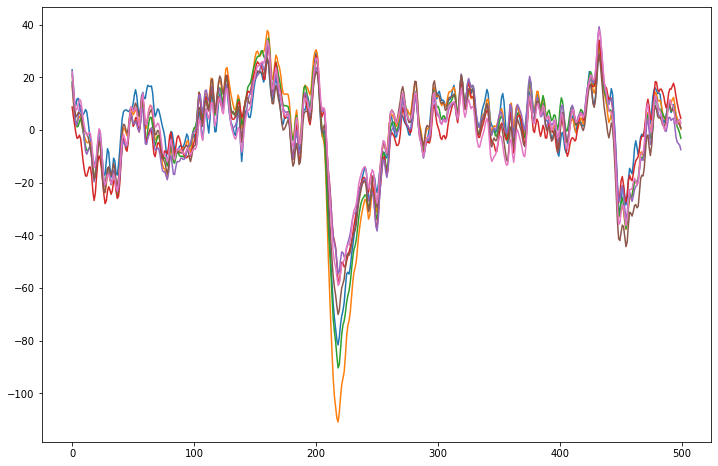

In [6]:
e_range = [3850, 4350]
plot_all_channels(ch_data[1:,e_range[0]:e_range[1]])

In [7]:
def center_channels(data):
    centered = []
    for ch in data:
        centered.append(ch - ch.mean())
    
    return np.array(centered)

def get_channel_threshold_count(channel, threshold):
    abs_ch = abs(channel)
    return np.sum(np.where(abs_ch > threshold))

def get_theshold_greatest(ch_data, threshold=0.05):
    max_ch = None
    cur_max = 0
    for i, ch in enumerate(ch_data):
        count = get_channel_threshold_count(ch, threshold)
        if count > cur_max:
            cur_max = count
            max_ch = i
            
    if max_ch == None:
        print('Warning: no channel data above threshold. Return 0 channel')
        
    return max_ch

In [8]:
class ICAFilter:
    """Get ICA mixing and unmixing matrices.
        Uses sklearn FastICA
    """
    def __init__(self, ch_data_segment, threshold=0.05, n_components=5, iter_limit=200):
        self.analysis_epoch = ch_data_segment
        self.threshold = threshold
        self.iter_limit = iter_limit
        
        if len(ch_data_segment) < n_components:
            n_components = len(ch_data_segment)
            
        self.n_components = n_components
        
    def fit(self):
        """When using sklearn FastICA, data should be shaped as (samples x channels)
            That is also the format of it's transform option. This ICAFilter favors
            a format of (channels x samples). Along with mixing matrices, you will
            see the occasional '.T' to transpose the data.
        """
        self.ica  = FastICA(n_components=self.n_components, max_iter=self.iter_limit)
        transformed = self.ica.fit_transform(self.analysis_epoch.T)
        unmixing = self.ica.components_
        thesh = np.ones((self.analysis_epoch.shape[0], 1)) * self.threshold
        print(unmixing.shape)
        print(thesh.shape)
        thresh_transform = max(abs(np.dot(unmixing, thesh)[:,0]))
        print(thresh_transform)
        print(transformed.shape)
        filter_ch = get_theshold_greatest(transformed.T, thresh_transform)
        # filter channel by modifying mix and unmix matrices
        mixing = self.ica.mixing_
        print(filter_ch)
        print(mixing.shape)
        mixing[:,filter_ch] = 0
        self.cleaning_matrix = np.dot(mixing, unmixing)
        
    def clean(self, ch_data):
        return np.dot(self.cleaning_matrix, ch_data)

    def plot_components(self):
        plt.subplot(1,1,1)
        transformed = np.dot(self.ica.components_, self.analysis_epoch).T
        for sig in transformed.T:
            plt.plot(sig)

        plt.tight_layout()
        plt.show()

(5, 7)
(7, 1)
0.1165567813073099
(1000, 5)
0
(7, 5)


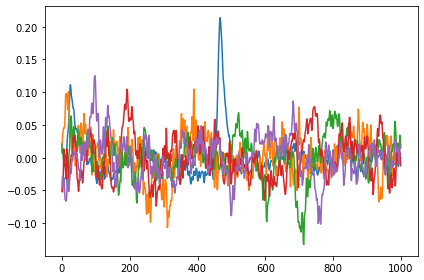

In [9]:
# e_range = [3850, 4350]
epoch_data = ch_data[1:,e_range[0]-250:e_range[1]+250]
# filtered_epoch = filter_with_ICA(epoch_data, threshold=60, iter_limit=5000)
blink_filter = ICAFilter(epoch_data, threshold=75, iter_limit=5000)
blink_filter.fit()
blink_filter.plot_components()

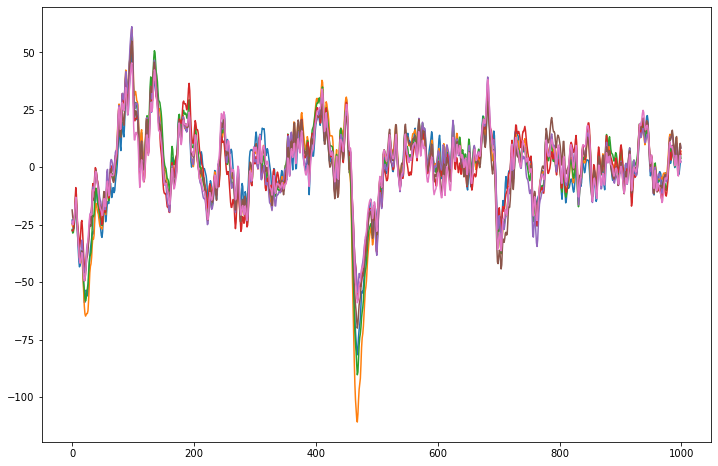

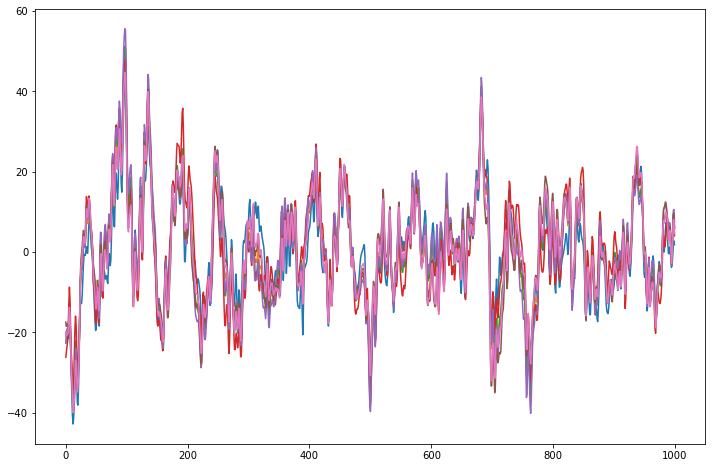

In [10]:
def plot_epoch(data, name):
    plt.title(name)
    for sig, color in zip(data.T, mcolors.TABLEAU_COLORS):
        plt.plot(sig, color=color)
        
    plt.show()
        
cleaned = blink_filter.clean(epoch_data)
plot_all_channels(epoch_data)
plot_all_channels(cleaned)

3.618001937866211 ms


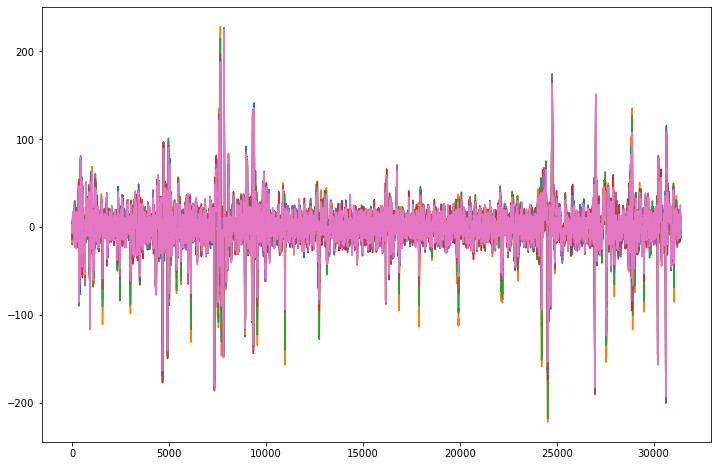

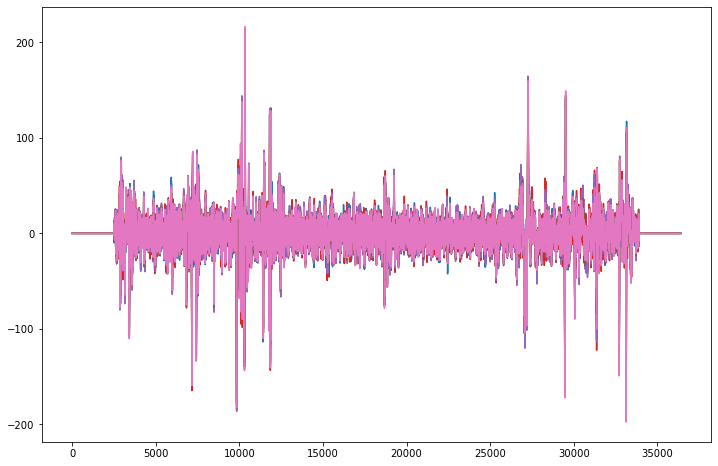

In [11]:
t = time.time()
for_clean = ch_data[1:].copy()
for_clean[:,0:2500] = 0
for_clean[:,-2500:] = 0
all_data_cleaned = blink_filter.clean(for_clean)
print(1000*(time.time() - t),'ms')
plot_all_channels(ch_data[1:,2500:-2500])
plot_all_channels(all_data_cleaned)

In [12]:
print(event_list)

[[3.385823965072632, 0, 3], [10.396805047988892, 0, 4], [18.39358687400818, 0, 1], [26.409024953842163, 0, 4], [32.41638994216919, 0, 2], [38.42348289489746, 0, 4], [44.43013095855713, 0, 4], [52.43594789505005, 0, 2], [59.43244910240173, 0, 3], [65.44359993934631, 0, 3], [72.44907808303833, 0, 4], [80.45319604873657, 0, 2], [88.46416401863098, 0, 2], [96.46643710136414, 0, 3], [104.47469687461853, 0, 2], [110.4878830909729, 0, 2], [116.49294900894165, 0, 4], [123.49427199363708, 0, 4], [129.49808287620544, 0, 4], [137.5113549232483, 0, 1]]


In [13]:
collect = []
# for i, ev in enumerate(event_list):
#     label = int(ev[0])
#     time = ev[1]
#     e_idx = ev[2]
#     if label == 9:
#         continue
        
#     y = 1 if label == 2 else 0
#     epoch = all_data_cleaned[:,e_idx:event_list[i+1][2]]
#     collect.append([epoch, y])
    
# df = pd.DataFrame(collect)
# df

# collect[19]
# all_data_cleaned[:,35663:36413]
# all_data_cleaned[1].shape
print(all_data_cleaned)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
import seaborn as sns
import mne
import os

In [15]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>

In [16]:
import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

Creating RawArray with float64 data, n_channels=7, n_times=36405
    Range : 0 ... 36404 =      0.000 ...   145.616 secs
Ready.


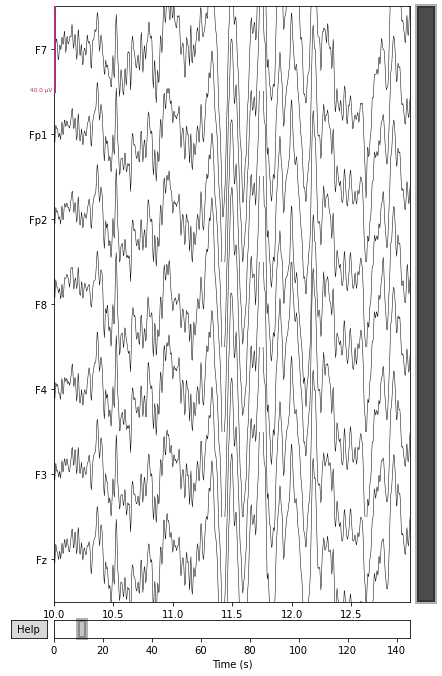

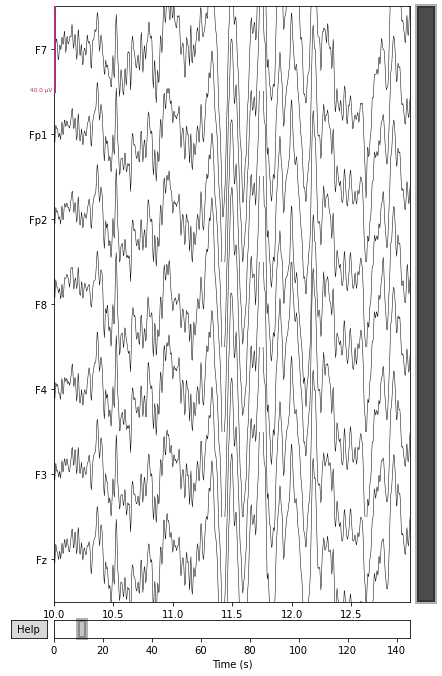

In [17]:
# params = BrainFlowInputParams()
# board = BoardShim(BoardIds.CYTON_BOARD.value, params)
eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD.value)

ch_types = ['eeg'] * len(all_data_cleaned)
# ch_names = BoardShim.get_eeg_names(BoardIds.CYTON_BOARD.value)
# ch_names = ['F9', 'F7', 'Fp1', 'Fp2', 'F8', 'F4', 'F3', 'Fz']
ch_names = ['F7', 'Fp1', 'Fp2', 'F8', 'F4', 'F3', 'Fz']
sfreq = BoardShim.get_sampling_rate(BoardIds.CYTON_BOARD.value)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
# raw = mne.io.RawArray(ch_data[1:]/1000000, info)
raw = mne.io.RawArray(all_data_cleaned/1000000, info)
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)
# raw.filter(.5, 50., fir_design='firwin', skip_by_annotation='edge')
# its time to plot something!

# print(eeg_channels)
# print(ch_types)
# print(ch_names)
# print(sfreq)
# print(info)
# print(ch_data[:-1].shape)
# raw.plot_psd(average=False)
raw.plot(duration=3, n_channels=7, start=10)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 3 components
Fitting ICA took 0.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-18-b66447a0d8b0>:5: UserWarning: Infinite value in PSD for epochs 0, 1, 2, 3, 4, 68, 69, 70, 71.
  ica.plot_properties(raw)


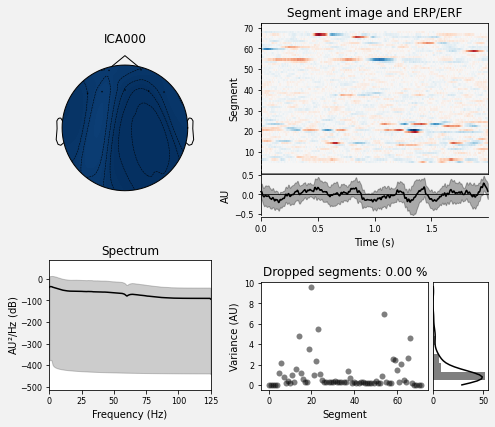

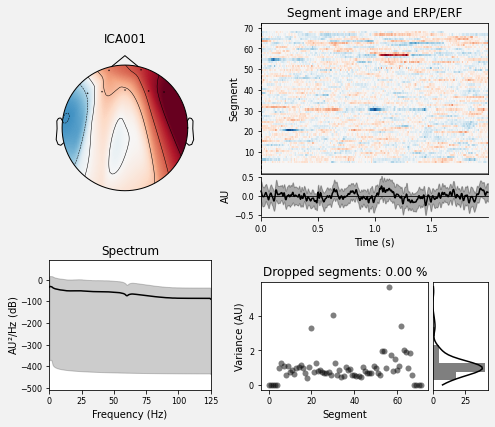

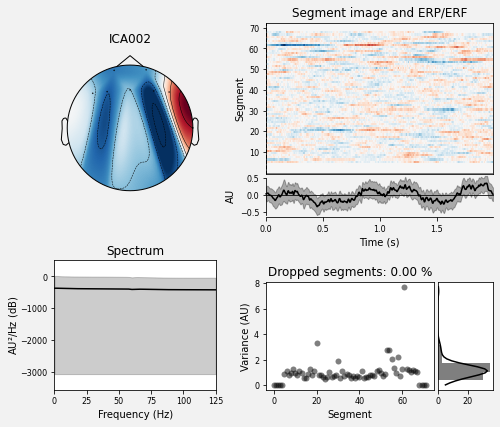

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [18]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=3, random_state=97, max_iter=800)
ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw)

Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


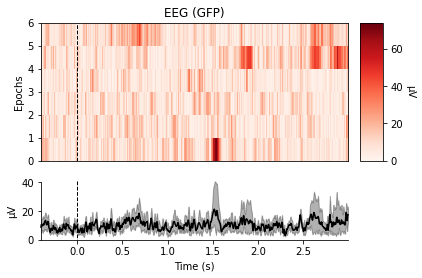

Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


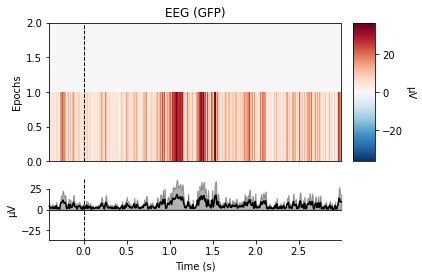

In [19]:
#  events = [(1, 'Say Hey Brain'),
#             (2, 'Think Hey Brain'),
#             (3, 'Visualize talking to the computer'),
#             (4, 'Type this sentence out on the computer')]

# scaler = StandardScaler()
# X_train_i = scaler.fit_transform(X_train_i)
scaler = StandardScaler()
ch_data_mne = all_data_cleaned/1000000;
# ch_data_mne = scaler.fit_transform(ch_data_mne)

fs = 250
epoched_data = []
for ev in event_list:
    pre_time = int(0.4 * fs)
    duration = 3 * fs
    start = int(ev[0] * fs)
    stop = start + duration
    start = start - pre_time
    epoched_data.append(ch_data_mne[:,start:stop])

events = np.array(event_list)
events[:,0] = events[:,0] * fs
events = events.astype(int)
# print(events)
event_dict = dict(say_hey=1, think_hey=2, visualize=3, typing=4)
epochs = mne.EpochsArray(epoched_data, info, tmin=-0.4, events=events, event_id=event_dict)

# eplot = epochs.plot(picks='eeg', show_scrollbars=False, events=events, event_id=event_dict, show=False)
# eplot.figure = (12,8)
# eplot.show()
# screenshot = eplot.screenshot()
# eplot.close()

# fig, ax = plt.figure(figure=(12,8))
# ax.imshow(screenshot)

conds_we_care_about = ['think_hey', 'say_hey']
# epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place

think = epochs['think_hey']
say = epochs['say_hey']
fig = think.plot_image()
fig = say.plot_image()

No baseline correction applied


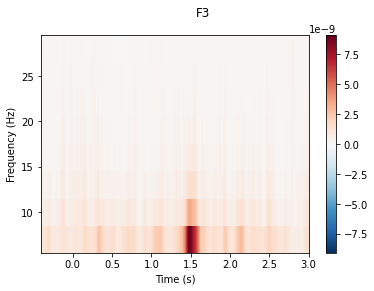

In [20]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(think, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
fig = power.plot(['F3'])

<class 'mne.evoked.EvokedArray'>
combining channels using "gfp"
combining channels using "gfp"


<ipython-input-21-5e108990dcb2>:5: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(dict(think=think_evoked, say=say_evoked), picks='all', legend='upper left', show_sensors='upper right')


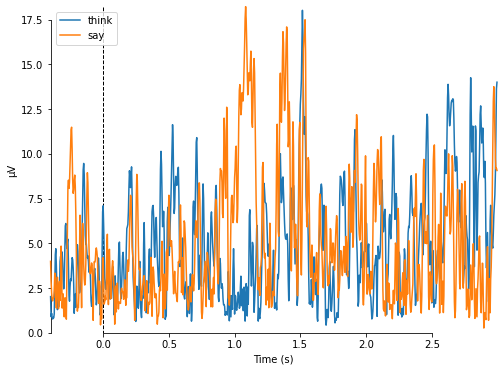

[<Figure size 576x432 with 1 Axes>]

In [21]:
think_evoked = think.average()
say_evoked = say.average()

print(type(think_evoked))
mne.viz.plot_compare_evokeds(dict(think=think_evoked, say=say_evoked), picks='all', legend='upper left', show_sensors='upper right')

In [22]:
epochs_train = epochs.copy().crop(tmin=0.4, tmax=2)
labels = epochs.events[:,-1]-1
# print(mne.get_config())
mne.set_log_level(verbose='WARNING')

In [23]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

mins, maxs = [],[]
for sample in epochs_data_train:
    for feature in sample:
        mins.append(min(feature))
        maxs.append(max(feature))

print(min(mins))
print(max(maxs))
# for ev in epochs_data_train:
#     print(ev)
#     for r in ev:
#         print(len(r))

# cv = ShuffleSplit(5, test_size=0.1, random_state=20)
# cv_split = cv.split(epochs_data_train[8:])

# lda = LinearDiscriminantAnalysis()
# csp = CSP(n_components=4, reg=None, log=True, norm_trace=True)

# clf = Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data_train[8:], labels, cv=cv, n_jobs=1)

# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
# print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

# csp.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

-0.00018636253876788182
0.0001491873176517551


In [24]:
from scipy.signal import butter, sosfiltfilt, sosfreqz 
import matplotlib.patches as patches

In [25]:
# print(events)
selector = list(range(1,9)) #+ [22] # 22 is the time data
ch_data = sorted_data[selector]
print(ch_data.shape)
# from Assignment 2
# Define our filter variables
fs = 250.0                      # Hz; sampling rate
dt = 1000/fs                    # ms; time between samples
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

(8, 36405)


In [26]:
# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 700    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 200    # ms
erp_end = 400      # ms

# Let's translate these into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP end

# We'll also create our channel labels here since the document only provided a figure
channels = np.array(['F9', 'F7', 'Fp1', 'Fp2', 'F8', 'F4', 'F3', 'Fz'])

[3 4 1 4 2 4 4 2 3 3 4 2 2 3 2 2 4 4 4 1]


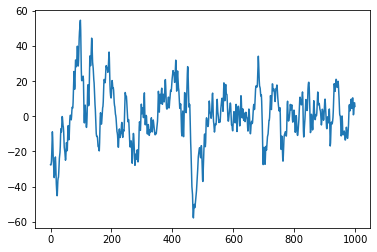

In [27]:

epoched_data = []
for ev in event_list:
    pre_time = int(0.4 * fs)
    duration = int(3 * fs)
    start = int(ev[0] * fs)
    stop = start + duration
    start = start - pre_time
#     epoched_data.append(ch_data_mne[:,start:stop])
 
#     print(ch_data.T.shape)
#     print(start, stop)
    data = all_data_cleaned.T[start:stop, :] - np.mean(all_data_cleaned.T[start:stop, :], 0)
#     print(ch_data.T[e_s+start:start+e_e, :].shape)
#     data = sosfiltfilt(sos, data, padlen=data.shape[1] - 1)
    data = data - np.mean(data[0:pre_time, :], 0)
    epoched_data.append(data)
    
epoched_data = np.array(epoched_data)
plt.plot(epoch_data[3])

ev_list = np.array([x[2] for x in event_list])
print(ev_list)
# events = np.array(event_list)
# events[:,0] = events[:,0] * fs
# events = events.astype(int)
# print(events)
# event_dict = dict(say_hey=1, think_hey=2, visualize=3, typing=4)

(6, 850, 7) (20, 850, 7)


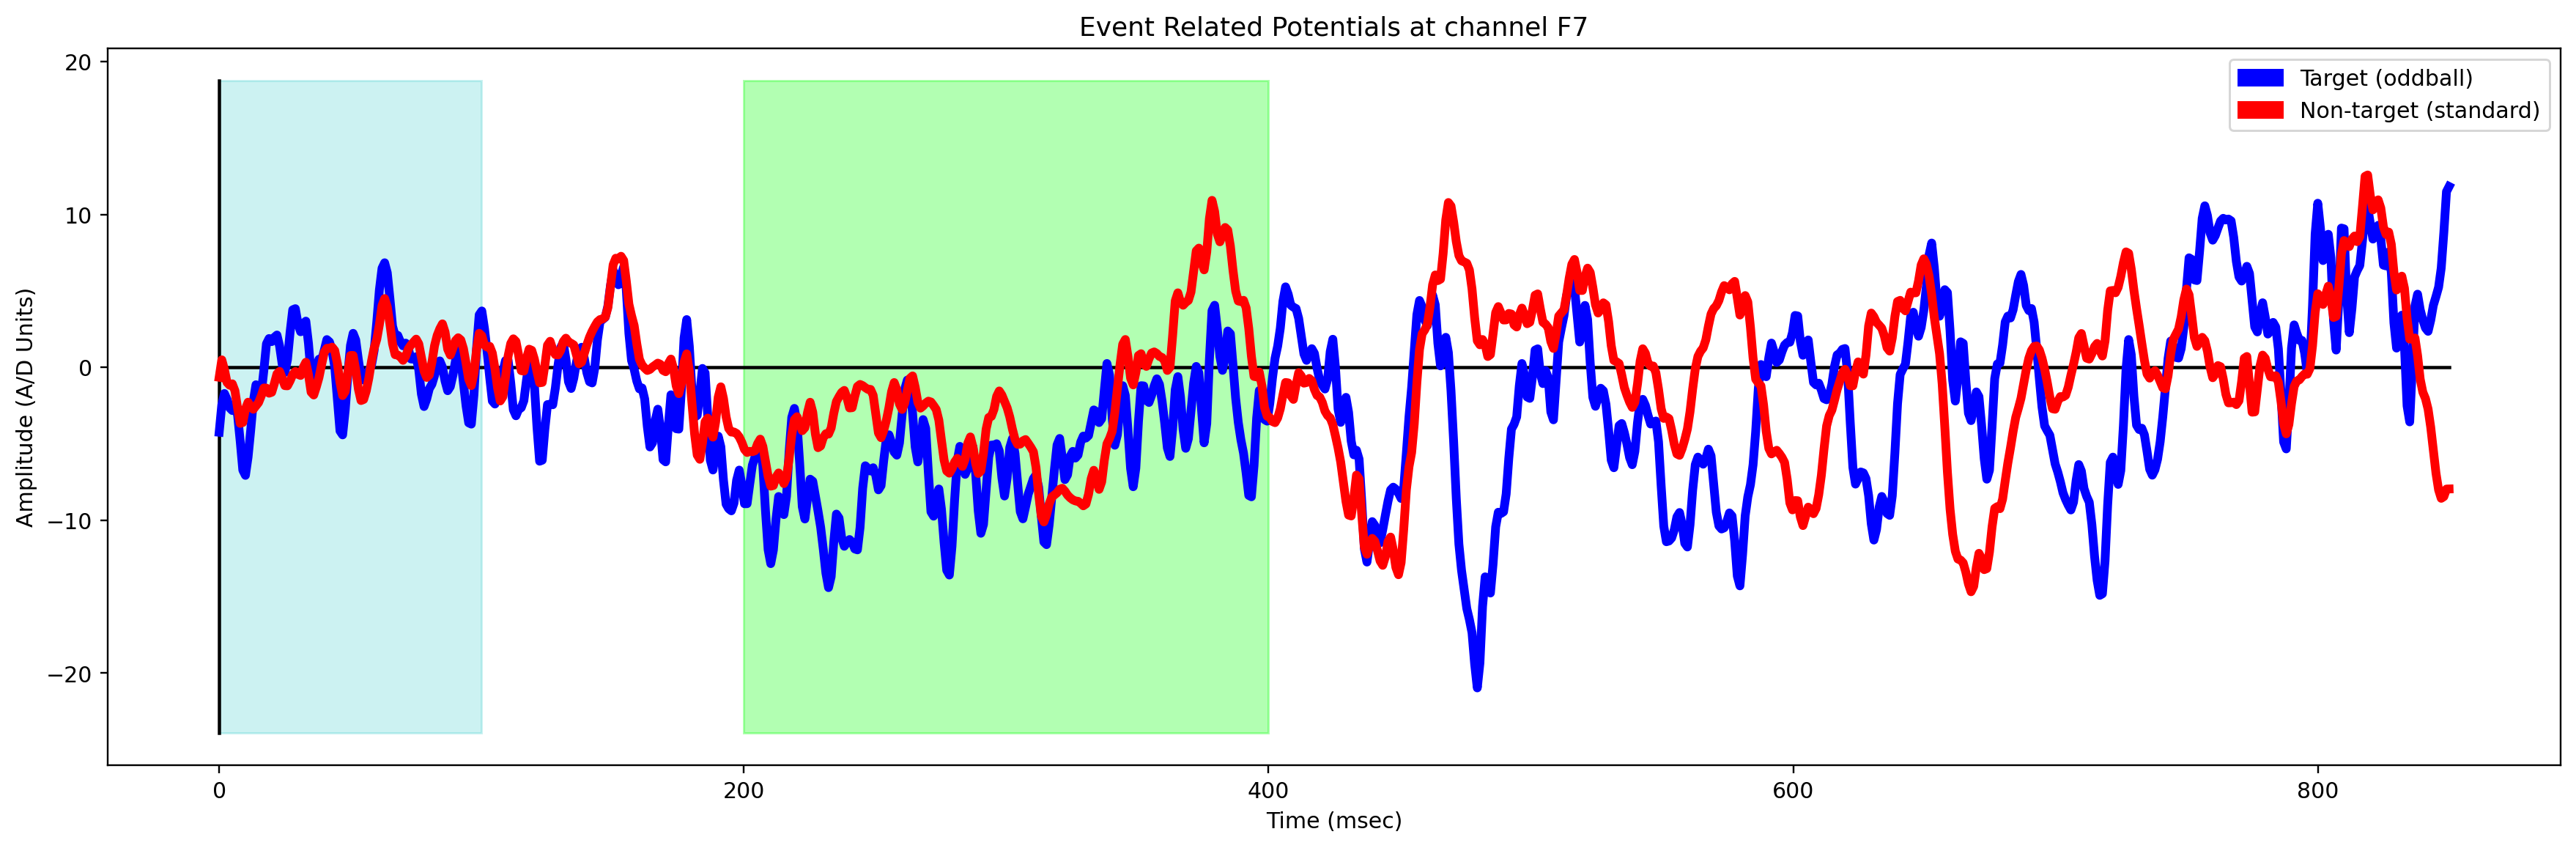

In [28]:
tar     = epoched_data[np.where(ev_list == 2)[0], :, :]
non_tar = epoched_data[np.where(ev_list != 0)[0], :, :]
print(tar.shape, non_tar.shape)

tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

chan = 'F7'
ch = np.where(channels == chan)[0][0]
times = np.linspace(0, int(3.4 * fs), epoched_data.shape[1] )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.show();


[6602    0    4]


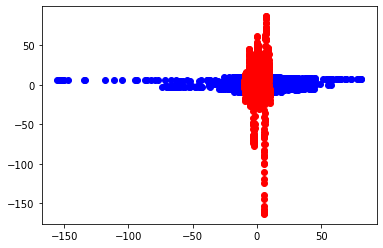

In [29]:
# ch_a = all_data_cleaned[2500:]
print(events[3])
ch_a = epoched_data[3][:,2]
ch_b = epoched_data[3][:,3]

t = np.linspace(-10,10, len(ch_a))

plt.scatter(ch_a, t, c='blue')
plt.scatter(t, ch_b, c='red')

Power = Variance of band limited signals
Power = the root mean square version of the signal